# Data discovery and data quality (11:00-11:30, Mo)

## Useful modules

The [`gwpy` library](https://gwpy.github.io/docs/stable/) maintained by Duncan Macleod provides many useful tools for analysis of gravitational-wave data.
[`gwdatafind`](https://gwdatafind.readthedocs.io/en/stable/), also maintained by Duncan Macleod, is used for data discovery.
Another tool that is useful is the [Glue](https://pypi.org/project/lscsoft-glue/) (Grid LSC User Environment) package.

These packages are all available on PyPI and can be installed with
```console
pip install gwpy gwdatafind lscsoft-glue
```
These are already installed on the LDG clusters. Let's also import some useful modules for later on.

In [1]:
import subprocess
import gwdatafind
from gwpy.timeseries import TimeSeries, StateVector, Bits

## The `gwf` data format
Most $h(t)$ strain data are stored in the `gwf` data format. This format bundles different "channels" together, which can be at different sampling rates. On one of the LDG clusters, the `FrChannels` command can be run on a `gwf` frame to see which channels it includes.

For example, running `FrChannels` on a low-latency $h(t)$ frame (which we will discuss in more detail later), we get
```console
(base) geoffrey.mo@ldas-pcdev1:/dev/shm/kafka/H1$ FrChannels H-H1_llhoft-1253900336-1.gwf
H1:GDS-CALIB_F_S_SQUARED 16
H1:GDS-CALIB_F_S_SQUARED_NOGATE 16
H1:GDS-CALIB_SRC_Q_INVERSE 16
H1:GDS-CALIB_SRC_Q_INVERSE_NOGATE 16
H1:GDS-CALIB_F_CC 16
H1:GDS-CALIB_F_CC_NOGATE 16
H1:GDS-CALIB_KAPPA_C 16
H1:GDS-CALIB_KAPPA_C_NOGATE 16
H1:GDS-CALIB_KAPPA_PUM_IMAGINARY 16
H1:GDS-CALIB_KAPPA_PUM_IMAGINARY_NOGATE 16
H1:GDS-CALIB_KAPPA_PUM_REAL 16
H1:GDS-CALIB_KAPPA_PUM_REAL_NOGATE 16
H1:GDS-CALIB_KAPPA_UIM_IMAGINARY 16
H1:GDS-CALIB_KAPPA_UIM_IMAGINARY_NOGATE 16
H1:GDS-CALIB_KAPPA_UIM_REAL 16
H1:GDS-CALIB_KAPPA_UIM_REAL_NOGATE 16
H1:GDS-CALIB_KAPPA_TST_IMAGINARY 16
H1:GDS-CALIB_KAPPA_TST_IMAGINARY_NOGATE 16
H1:GDS-CALIB_KAPPA_TST_REAL 16
H1:GDS-CALIB_KAPPA_TST_REAL_NOGATE 16
H1:GDS-CALIB_STATE_VECTOR 16
H1:GDS-CALIB_STRAIN 16384
H1:GDS-CALIB_STRAIN_CLEAN 16384
H1:DMT-DQ_VECTOR 16
H1:DMT-DQ_VECTOR_GATED 16
H1:GDS-GATED_STRAIN 16384
H1:IDQ-OK_OVL_16_4096 128
H1:IDQ-RANK_OVL_16_4096 128
H1:IDQ-FAP_OVL_16_4096 128
H1:IDQ-EFF_OVL_16_4096 128
H1:IDQ-LOGLIKE_OVL_16_4096 128
H1:IDQ-PGLITCH_OVL_16_4096 128
```

32 channels are included in this one `.gwf` frame. These channels are named as follows:

```console
{IFO}:{SUBSYSTEM}-{SOMEWHAT_DESCRIPTIVE_NAME}.
```
In the `FrChannels` output, the channel name is followed by a sampling rate in Hertz.

## Data discovery

LIGO and Virgo data are stored in various locations on the LIGO Data Grid. Some of this can be accessed on local machines via `HTTP`, but I will focus on accessing data from the Caltech (CIT) cluster. Much of this is generalizable to other clusters.

### Low-latency h(t)
The lowest-latency gravitational-wave data is stored at CIT at `/dev/shm/kafka` in 1-second `gwf` frames. Typically, these frames are stored in a rolling 300 second buffer, meaning that data disappears from this directory after five minutes.

Let's look at the structure of the names of these files, using `H-H1_llhoft-1253900336-1.gwf` as an example.
 - `H` stands for the Hanford site
 - `H1` stands for the H1 detector
 - `llhoft`, short for low latency h of t, says what type of frame this is
 - `1253900336` is the starting GPS time of the frame
 - `1` is the length in seconds of data contained in this frame

Only channels needed for low-latency processing of gravitational-wave data are included in these frames, as seen in the `FrChannels` output above. The most important of these channels are the strain $h(t)$ channels, sampled at 16384 Hz.

### "Medium"-latency h(t)
What if one wants to look for data that's older than 5 minutes? Look in `/ifocache/llcache/kafka`, where the same 1-second frames as in `/dev/shm/kafka` are stored. For example, $10^4$ seconds of H1 llhoft data is stored in `/ifocache/llcache/kafka/H1/H-H1_llhoft-125390`.

### "High"-latency h(t)
The highest latency frames are stored at `/archive/frames/`. For example, the archived version of the data at 1253900336 is at `/archive/frames/O3/hoft/H1/H-H1_HOFT_C00-12539/H-H1_HOFT_C00-1253900288-4096.gwf`. 

Running `FrChannels` on the frames we've discussed, we find that there are the same 32 channels in all of the latencies. However, the detectors record far more channels than that, which are stored in the "raw" frames. These are stored at `/archive/frames/O3/raw/H1/`. Let's see how many channels are in these frames:

In [2]:
subprocess.check_output("FrChannels /archive/frames/O3/raw/H1/H-H1_R-12539/H-H1_R-1253909568-64.gwf | wc -l", shell=True)

b'254332\n'

These 254 332 channels record far more information than those packaged into the low-latency frames, but are typically sampled at a much lower rate (as low as 1 Hz). 

### Using gwdatafind
While it's quick and convenient to go straight to the directory containing the frame, sometimes it's easier to have the machine do it for you. For that, we'll use [`gwdatafind.find_urls()`](https://gwdatafind.readthedocs.io/en/stable/api/gwdatafind.find_urls.html).

As an example, let's try finding the data for GW150914 in H1. The merger time, according to the [GWOSC](https://www.gw-openscience.org/events/GW150914/), was 1126259462. Let's look for data spanning some range around the merger time.

In [3]:
t_merge = 1126259462
t_start = t_merge - 5
t_end = t_merge + 2

`gwdatafind` takes integer start and stop times, and also requires the input of a frame type. We'll use `H1_HOFT_C00` as the frame type.

In [4]:
urls = gwdatafind.find_urls("H", "H1_HOFT_C00", t_start, t_end)
print(urls)

['file://localhost/hdfs/frames/ER8/hoft/H1/H-H1_HOFT_C00-11262/H-H1_HOFT_C00-1126256640-4096.gwf']


It happens that the data we're looking for is all in one big `gwf` frame. However, this is not always the case. Let's make a cache, which can include multiple frame files, before reading in the frame with `gwpy.timeseries`.

In [5]:
from glue.lal import Cache
cache = Cache.from_urls(urls)

timeseries = TimeSeries.read(cache, "H1:GDS-CALIB_STRAIN", start=t_start, end=t_end)
print(timeseries)

TimeSeries([-3.74409308e-19, -3.70756562e-19, -3.60706854e-19,
            ...,  1.60928047e-19,  1.58609837e-19,
             1.78634861e-19]
           unit: dimensionless,
           t0: 1126259457.0 s,
           dt: 6.103515625e-05 s,
           name: H1:GDS-CALIB_STRAIN,
           channel: H1:GDS-CALIB_STRAIN)


### Visualizing data using gwpy
Now that we have the timeseries read in, we can do things with it, including visualization. We'll first plot the raw $h(t)$, then look at a Qscan.

In [6]:
ts_plot = timeseries.plot()
ts_plot.show()

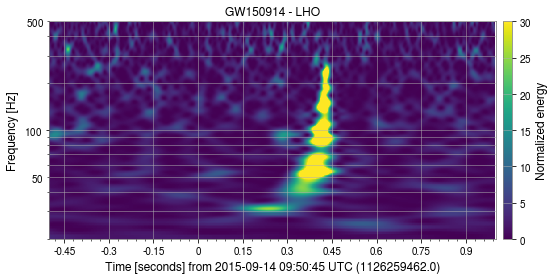

In [7]:
qspecgram = timeseries.q_transform(frange=(20,1000), gps=t_merge, outseg=(t_merge-0.5, t_merge+1))
plt = qspecgram.plot(figsize=[8, 4])
ax = plt.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.set_title('GW150914 - LHO')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=(0, 30))
plt.show()

We see a nice chirp, which is what we expect!

## Data quality

Now we'll move on to looking at data quality. 

### State vectors
All the channels recorded are useful for data quality purposes, but we'll focus on some of the more immediately available and recognizable channels, such as the `GDS-CALIB_STATE_VECTOR` and `DMT-DQ_VECTOR`.

As the name suggests, these channels are vectors, containing multiple axes of information.
Let's take a look at what information they contain

In [8]:
dqvector = TimeSeries.read(cache, 'H1:GDS-CALIB_STATE_VECTOR', start=t_start, end=t_end)
print(dqvector)

TimeSeries([2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527, 2527,
            2527, 2527, 2527, 2527]
           unit: dimensionless,
           t0: 1126259457.0 s,
           dt: 0.0625 s,
           name: H1:GDS-CALIB_STATE_VECTOR,
           channel: H1:GDS-CALIB_STATE_V

We see that each entry here is `2527`. In binary, that is:

In [9]:
bin(2527)

'0b100111011111'

This 12-bit number records 12 binary states. We can use `gwpy.timeseries.Bits` and `gwpy.timeseries.StateVector` to label them. Here, we'll just label the first two bits as an example.

In [10]:
state_vector_bits = Bits(
    channel='GDS-CALIB_STATE_VECTOR',
    bits={
        0: 'HOFT_OK',
        1: 'OBSERVATION_INTENT'
    },
    description={
        'HOFT_OK': 'h(t) was successfully computed',
        'OBSERVATION_INTENT': '"observation intent" button is pushed',
    }
)

statevector = StateVector.read(cache, "H1:GDS-CALIB_STATE_VECTOR", start=t_start, end=t_end, bits=state_vector_bits)
print(statevector.get_bit_series())

StateTimeSeriesDict([('HOFT_OK', <StateTimeSeries([ True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
                   True,  True,  True,  True,  True,  True,
       

So we see that the `HOFT_OK` and `OBSERVATION_INTENT` bits are `True` for the duration of the event, as expected. 

### iDQ statistical glitch inference
Another useful tool for looking at data quality is iDQ, maintained by Reed Essick and Patrick Godwin, among others. iDQ classifies glitches in $h(t)$ based on statistical inference of auxiliary channels. These outputs are packaged into low-latency frames. Most notably, the `H1:IDQ-PGLITCH_OVL_16_4096` channel is included, which spits out $P(\mathrm{glitch})$ at 128 Hz. This channel wasn't packaged in the frames in 2015 and so isn't available for GW150914, but we can look at a more recent frame as an example.

In [13]:
idq = TimeSeries.read('/ifocache/llcache/kafka/H1/H-H1_llhoft-125390/H-H1_llhoft-1253902255-1.gwf', 'H1:IDQ-PGLITCH_OVL_16_4096')
print(idq)

TimeSeries([0.25867395, 0.25867395, 0.25867395, 0.25867395,
            0.25867395, 0.25867395, 0.99082501, 0.25867395,
            0.25867395, 0.25867395, 0.25867395, 0.25867395,
            0.25867395, 0.25867395, 0.99082501, 0.25867395,
            0.25867395, 0.25867395, 0.25867395, 0.25867395,
            0.25867395, 0.25867395, 0.99082501, 0.25867395,
            0.25867395, 0.25867395, 0.25867395, 0.25867395,
            0.25867395, 0.25867395, 0.99082501, 0.25867395,
            0.25867395, 0.25867395, 0.25867395, 0.25867395,
            0.25867395, 0.25867395, 0.25867395, 0.25867395,
            0.25867395, 0.25867395, 0.25867395, 0.25867395,
            0.25867395, 0.25867395, 0.25867395, 0.25867395,
            0.25867395, 0.25867395, 0.25867395, 0.25867395,
            0.25867395, 0.44633282, 0.44633282, 0.44633282,
            0.44633282, 0.44633282, 0.44633282, 0.68606586,
            0.54686778, 0.54686778, 0.68606586, 0.54686778,
            0.54686778, 0.54686778, 0.54

The $P(\mathrm{glitch})$ value fluctuates between 0 and 1, spiking to probabilities in the high 0.9s at times, but otherwise staying low at around 0.25.